# Data Description

The data is an email spam dataset, consisting of 4601 email messages with 57 features. Feature descriptions are found in this [link](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.info.txt). We have divided the data into a training set (3605 emails) and test set (1536 emails) with accompanying labels (1=spam,0=not spam)

# Assumptions

Fit a Beta-bernoulli naive Bayes classifier on the binarized data from the Data Processing section. Since there are a lot of spam and non-spam emails, you do not need to assume any prior on the class label. In other words, the class label prior $\pi_c$ can be estimated using ML(maximum likelyhood) and you can use $\pi_c^{ML}$ as a plug-in estimator for testing.

On the other hand, you should assume a prior Beta(α, α) on the feature distribution (note that the two hyperparameters for the Beta prior are set to be equal). For each value of α = {0, 0.5, 1, 1.5, 2, · · · , 100}, fit the classifier on the training data and compute its error rate (i.e., percentage of emails classified wrongly) on the test data. For the features (i.e., when computing p(x|y)), use Bayesian (i.e., posterior predictive) training and testing.

# Setup

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

# A function to enable displaying the tables side by side
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which 
    contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

# set seaborn style
sns.set()

Creating DataFrames for sample data Xtrain,ytrain,Xtest and ytest. 

Xtrain : `df_Xtrain`

ytrain : `df_ytrain`

Xtest  : `df_Xtest`

ytest  : `df_ytest`

In [2]:
# Creating a DataFrame from csv file for Xtrain. 
df_Xtrain = pd.read_csv('spamData_Xtrain.csv',header=None)
# This DataFrame is going to be binarized. 
df_Xtrain_Binary = pd.read_csv('spamData_Xtrain.csv',header=None)
# Creating a DataFrame from csv file for ytrain.
df_ytrain = pd.read_csv('spamData_ytrain.csv',header=None)
df_ytrain.columns = ['spam']

# Creating a DataFrame from csv file for Xtest. 
df_Xtest = pd.read_csv('spamData_Xtest.csv',header=None)
# This DataFrame is going to be binarized. 
df_Xtest_Binary = pd.read_csv('spamData_Xtest.csv',header=None)
# Creating a DataFrame from csv file for ytrain.
df_ytest = pd.read_csv('spamData_ytest.csv',header=None)
df_ytest.columns = ['spam']

___

# Implementation

## 1. Data Exploration

In [3]:
df_Xtrain.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,...,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000
mean,0.110189,0.201971,0.293651,0.039791,0.312551,0.097785,0.119719,0.103269,0.094157,0.237445,...,0.030486,0.034066,0.141105,0.018234,0.265909,0.076427,0.046795,5.934619,55.575204,289.059054
std,0.317308,1.222545,0.525776,0.954668,0.662629,0.266590,0.414767,0.348431,0.290575,0.571698,...,0.309172,0.201550,0.279497,0.117578,0.617612,0.231515,0.374790,38.368377,226.652630,642.779087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.592000,6.000000,36.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.068000,0.000000,0.000000,0.000000,0.000000,2.287000,15.000000,94.000000
75%,0.000000,0.000000,0.430000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.189000,0.000000,0.324000,0.058000,0.000000,3.787000,45.000000,273.000000
max,4.340000,14.280000,5.100000,42.730000,10.000000,3.570000,7.270000,4.680000,5.260000,5.260000,...,10.000000,4.367000,9.752000,4.081000,9.575000,5.300000,13.129000,1102.500000,9989.000000,15841.000000


In [4]:
df_ytrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3065 entries, 0 to 3064
Data columns (total 1 columns):
spam    3065 non-null int64
dtypes: int64(1)
memory usage: 24.0 KB


After a brief exploration of the data, I decide to use the mean of each column to be treshold for binarization.

___

## 2. Binarization

In [5]:
def Binarize(column):
    """For the input column, set values larger than the column mean to be 1, 
    rest set to be 0."""
    column = column > column.mean()
    return column

In [6]:
# Apply function to each column of the Xtrain DataFrame.
df_Xtrain_Binary = df_Xtrain_Binary.apply(Binarize)

In [ ]:
# Apply function to each column of the Xtrain DataFrame.
df_Xtest_Binary = df_Xtest_Binary.apply(Binarize)

___

## 3. Comput Error Rate when $\alpha$ = 1

* __Class label__

The class label prior $\pi_c$ is estimated using ML (maximum likelihood).

There're only two class, spam (c=1) and non-spam (c=0).

$$\pi_{c=1} = \frac{number\;of\;spam}{number\;of\;training\;samples}$$ 

$$\pi_{c=0} = \frac{number\;of\;non-spam}{number\;of\;training\;samples}$$


In [8]:
print('The number of spam in the ytrain is',df_ytrain.sum().values[0],'.')
print('The number of training samples is',df_ytrain.shape[0],'.')

The number of spam in the ytrain is 1234 .
The number of training samples is 3065 .


$\pi_{c=1} = \frac{1234}{3065}$ = 0.4026

$\pi_{c=0} = \frac{1831}{3065}$ = 0.5974

In [9]:
# Set the class label prior
pi_1 = 0.4026
pi_0 = 0.5974

* __ Feature __

Assume a prior Beta($\alpha$,$\alpha$) on the feature distribution. $\alpha$={0,0.5,1,1.5,2,...,100}.

Then $P({x_j}\mid {y=c,T})$ is posterior predictive distribution for Beta-binomial,

$$P({x_j =1}\mid {y=c,T}) = {\overline\theta_{jc}} = \frac{N_{jc}+\alpha}{N_c + 2\alpha}$$

$N_{jc}$: number of examples in class c where ${\;feature}_j$ =1.

$N_{c}$: number of training examples of class c.

### 3.1 Calculate $P({x_j}\mid {y=c,T})$ of each feature

$$P({x_j =1}\mid {y=c,T}) = {\overline\theta_{jc}} = \frac{N_{jc}+\alpha}{N_c + 2\alpha}$$

In [10]:
def getBetaBinomial(column,ytrain,alpha,c):
    
    """For each feature(column), calculate the probability 
    P(feature = 1 | class = 1 or 0 , training data) """
        
    # Index of sample labled as spam
    c1_index = ytrain.iloc[:,0] == 1
    # Index of sample labeld as non-spam
    c0_index = ytrain.iloc[:,0] == 0
    
    if c == 1:
        # Number of training samples labeled as spam.
        Nc = ytrain.sum().values[0]
        # Number of training samples labeld as spam and feature = 1.
        Njc = column[c1_index].sum()
    
    elif c == 0:
        # Number of training samples labeled as non-spam.
        Nc = ytrain.shape[0] - ytrain.sum().values[0]
        # Number of training samples labeld as non-spam and feature = 1.
        Njc = column[c0_index].sum()
        
    # Return the P(feature = 1 | class = 1 , training data)
    # To prevent numerical underflow, return log(P(feature = 1 | class = 1 , training data))
    return np.log10((Njc + alpha)/(Nc+2*alpha))

In [11]:
# Let alpha = 1
alpha = 1

Creating a DataFrame __df_theta_1__ to store the $\;\overline\theta_{j,c=1}$.

In [12]:
theta_1 = df_Xtrain_Binary.apply(getBetaBinomial,args=(df_ytrain,alpha,1))
df_theta_1 = pd.DataFrame(theta_1,columns=['theta_1'])
df_theta_1 = df_theta_1.transpose()

Creating a DataFrame __df_theta_0__ to store the $\;\overline\theta_{j,c=0}$.

In [13]:
theta_0 = df_Xtrain_Binary.apply(getBetaBinomial,args=(df_ytrain,alpha,0))
df_theta_0 = pd.DataFrame(theta_0,columns=['theta_0'])
df_theta_0 = df_theta_0.transpose()

____

### 3.2 Calculate $P({y=c}\mid {x,T})$  and Make predictions

Known:

$\pi_{c=1}$ :                `pi_1` 

$\pi_{c=0}$ :                `pi_0`

$\overline\theta_{j,c=1}$: `df_theta_1`

$\overline\theta_{j,c=0}$: `df_theta_0`

__T__:     `df_Xtrain_Binary` , `df_ytrain`, `df_Xtest_Binary`, `df_ytest`

Since there's only two class "spam" and "not spam"

$$P({y=1}\mid {x,T}) \; \propto \; \log(\overline{\pi}_{c=1}) + \sum_{j=1}^D\log(\overline{\theta}_{j,c=1}^{\parallel (x_j=1)}\times\overline{\theta}_{j,c=0}^{\parallel (x_j=0)})$$ 

$$P({y=0}\mid {x,T}) \; \propto \; \log(\overline{\pi}_{c=0}) + \sum_{j=0}^D\log(\overline{\theta}_{j,c=0}^{\parallel (x_j=1)}\times\overline{\theta}_{j,c=1}^{\parallel (x_j=0)})$$ 

$\parallel$ : Indicator variable

T : training samples

D : number of feature

j : feature index

In practice, $\log (P({y=c}\mid {x,T}))$ is used in order to prevent numerical underflow

In [14]:
# helper function
def mul(row,theta):
    """Row multiplication"""
    result = (row*theta).sum()
    
    return result

 Calculate $P({y=c}\mid {x,T})$ for the two classes 'spam' and 'non-spam'.

In [15]:
def getClassProb(X,theta_0,theta_1,pi_0,pi_1,c):
    """Calculate the probability the sample belongs 
       to class c (1: spam , 0:non-spam)"""
    ones = X == 1
    zeros = X == 0
    
    # for class=1: spam
    if c =='spam':
        Prob = np.log10(pi_1) + ones.apply(mul,args=(theta_1.iloc[0,:],),axis=1)\
        + zeros.apply(mul,args=(theta_0.iloc[0,:],),axis=1)   
    # for calss=0: non-spam
    elif c =='non-spam':
        Prob = np.log10(pi_0) + ones.apply(mul,args=(theta_0.iloc[0,:],),axis=1)\
        + zeros.apply(mul,args=(theta_1.iloc[0,:],),axis=1)

    return Prob

In [16]:
def pred(X,theta_0,theta_1,pi_0,pi_1):
    """Input the sample datas, theta of spam and non-spam, 
    and pi of spam and non-spam, then make prediction on whether
    the sample is spam"""
    
    # Use function getClassProb to calcualte the probability 
    # of each class. 
    probSpam = getClassProb(X,theta_0,theta_1,pi_0,pi_1,'spam')
    probNonSpam = getClassProb(X,theta_0,theta_1,pi_0,pi_1,'non-spam')
    
    # Decide whether the email is spam by comparing 
    # the probability of spam and non-spam
    prediction = pd.DataFrame(probSpam-probNonSpam,columns=['spam'])
    prediction_Binary = prediction > 0
    return prediction_Binary

In [17]:
def getErrorRate(prediction,y):
    """Calculate the percentage of emails classified wrongly"""
    compare = prediction == y
    errorRate = 1-compare.sum().values[0]/compare.shape[0]
    return errorRate

Make predictions for samples in Xtrain and Xtest data set.

In [18]:
# Make predictions for samples in Xtrain. 
prediction_train = pred(df_Xtrain_Binary,df_theta_0,df_theta_1,pi_0,pi_1)
# Make predictions for samples in Xtest. 
prediction_test = pred(df_Xtest_Binary,df_theta_0,df_theta_1,pi_0,pi_1)

### 3.3 Calculate error rate

Calculate error rate for the training samples.

In [19]:
trainErrorRate = getErrorRate(prediction_train,df_ytrain)

In [20]:
trainErrorRate

0.25742251223491031

Calculate error rate for the test samples.

In [21]:
testErrorRate = getErrorRate(prediction_test,df_ytest)

In [22]:
testErrorRate

0.263671875

### 4. Find the optimum $\alpha$ in {0,0.5,1,1.5,2,...,100}

Compute the error rate on the train and test data for $\alpha$ in {0,0.5,1,1.5,2,...,100}, find the $\alpha$ which produce least error rate on the test data. 

In [23]:
# set alpha
alpha = np.arange(0,100.5,0.5)

Create a DataFrame to store the error rate on the train and test data. 

In [24]:
df_error = pd.DataFrame(np.zeros((len(alpha),2)),columns=['Train','Test'],index=alpha)
df_error.index.name = 'alpha'

Note! This process takes about 3min. you could jump to step 28 as in you can get the the output directly from the csv file "Q1_ErrorRates.csv"

In [27]:
counter  = 0

for i in alpha:    
    # calculate the posterior predictive distribution for Beta-binomial
    theta_1 = df_Xtrain_Binary.apply(getBetaBinomial,args=(df_ytrain,i,1))
    df_theta_1 = pd.DataFrame(theta_1,columns=['theta_1'])
    df_theta_1 = df_theta_1.transpose()
    
    theta_0 = df_Xtrain_Binary.apply(getBetaBinomial,args=(df_ytrain,i,0))
    df_theta_0 = pd.DataFrame(theta_0,columns=['theta_0'])
    df_theta_0 = df_theta_0.transpose()
    
    # Make predictions for the 'spam' and 'non-spam'.
    prediction_train = pred(df_Xtrain_Binary,df_theta_0,df_theta_1,pi_0,pi_1) 
    prediction_test = pred(df_Xtest_Binary,df_theta_0,df_theta_1,pi_0,pi_1)
    
    # Calculate error rate
    trainErrorRate = getErrorRate(prediction_train,df_ytrain)
    testErrorRate = getErrorRate(prediction_test,df_ytest)
    
    # Store the error rate
    row_entry = [trainErrorRate,testErrorRate]
    df_error.iloc[counter,:] = row_entry
    counter  = counter+1
    
# Save the error rates to a csv file.
df_error.to_csv('Q1_ErrorRates.csv')

"\ncounter  = 0\n\nfor i in alpha:    \n    # calculate the posterior predictive distribution for Beta-binomial\n    theta_1 = df_Xtrain_Binary.apply(getBetaBinomial,args=(df_ytrain,i,1))\n    df_theta_1 = pd.DataFrame(theta_1,columns=['theta_1'])\n    df_theta_1 = df_theta_1.transpose()\n    \n    theta_0 = df_Xtrain_Binary.apply(getBetaBinomial,args=(df_ytrain,i,0))\n    df_theta_0 = pd.DataFrame(theta_0,columns=['theta_0'])\n    df_theta_0 = df_theta_0.transpose()\n    \n    # Make predictions for the 'spam' and 'non-spam'.\n    prediction_train = pred(df_Xtrain_Binary,df_theta_0,df_theta_1,pi_0,pi_1) \n    prediction_test = pred(df_Xtest_Binary,df_theta_0,df_theta_1,pi_0,pi_1)\n    \n    # Calculate error rate\n    trainErrorRate = getErrorRate(prediction_train,df_ytrain)\n    testErrorRate = getErrorRate(prediction_test,df_ytest)\n    \n    # Store the error rate\n    row_entry = [trainErrorRate,testErrorRate]\n    df_error.iloc[counter,:] = row_entry\n    counter  = counter+1\n  

In [28]:
# create the df_error dataframe by reading from the csv file
df_error = pd.read_csv('Q1_ErrorRates.csv')

In [29]:
df_error.describe()

,alpha,Train,Test
count,201.00000,201.000000,201.000000
mean,50.00000,0.141365,0.126568
std,29.08393,0.032353,0.031550
min,0.00000,0.093638,0.089193
25%,25.00000,0.115498,0.106120
50%,50.00000,0.142904,0.121094
75%,75.00000,0.161175,0.140625
max,100.00000,0.289723,0.302083


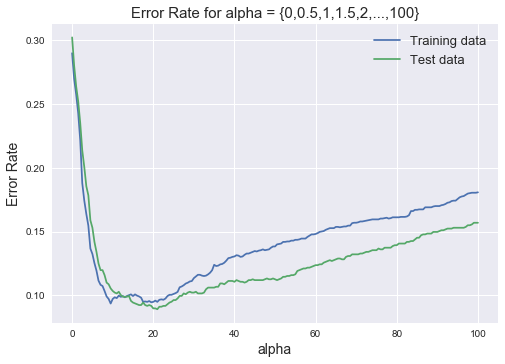

In [30]:
x = alpha
y1 = df_error.Train.values
y2 = df_error.Test.values

_ = plt.plot(x, y1)
_ = plt.plot(x, y2)

plt.title('Error Rate for alpha = {0,0.5,1,1.5,2,...,100}',fontsize=15)
plt.xlabel('alpha', fontsize=14)
plt.ylabel('Error Rate', fontsize=14)

# legend
plt.legend(('Training data', 'Test data'),fontsize=13)
plt.show()

The graph above shows that there's a minimum point, so there's an optimum alpha which produces the minimum error rate. 

Find the index of the minimum value in column Test.

In [31]:
df_error.Test.idxmin()

42

The optimum alpha in {0,0.5,1,1.5,...,100}

In [32]:
alpha[42]

21.0

Training and testing error rates for $\alpha$ = 1, 10 and 100.

In [33]:
df_error.iloc[[0,20,200]]

,alpha,Train,Test
0,0.0,0.289723,0.302083
20,10.0,0.097227,0.103516
200,100.0,0.180750,0.156901
